In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster, wait
import dask.array as da
import matplotlib.pyplot as plt
import cmocean
from MHW_daily_calcs import *

In [22]:
climyrs=[1993,2023]
qtile=0.90
smoothmethod='tri'
window=10

smoothedClim=True
smoothedTrend=True

In [2]:
fforig=xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetrIndiv/anomDetrByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L005_j000_ocean_1d_surface_tso.nc',decode_times=False)
ffnew=xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetrIndiv2/anomDetrByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L005_j000_ocean_1d_surface_tso.nc',decode_times=False)
ffnewS=xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/anomDetrByLead_ClimStri10_TrStri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L005_j000_ocean_1d_surface_tso.nc',decode_times=False)

In [3]:
fforig

<xarray.Dataset> Size: 1GB
Dimensions:   (lat: 60, lon: 360, reftime: 378, r: 20)
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  float64 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) int64 3kB 0 31 59 90 120 ... 11382 11413 11443 11474
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sst_an    (reftime, r, lat, lon) float64 1GB ...

In [4]:
ffnew

<xarray.Dataset> Size: 1GB
Dimensions:   (lat: 60, lon: 360, reftime: 378, r: 20)
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  float64 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) int64 3kB 0 31 59 90 120 ... 11382 11413 11443 11474
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sst_an    (reftime, r, lat, lon) float64 1GB ...

In [5]:
ffnewS

<xarray.Dataset> Size: 1GB
Dimensions:   (lat: 60, lon: 360, reftime: 378, r: 20)
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
    leadtime  float64 8B ...
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) int64 3kB 0 31 59 90 120 ... 11382 11413 11443 11474
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sst_an    (reftime, r, lat, lon) float64 1GB ...

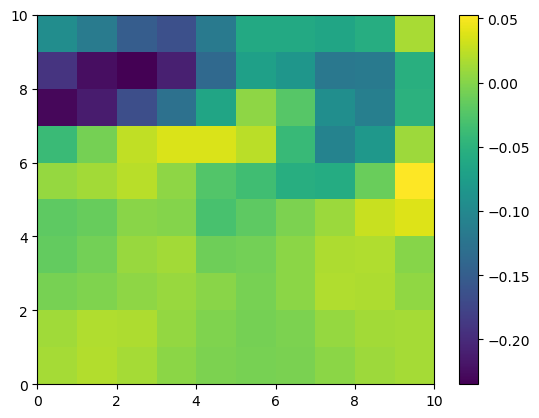

In [9]:
plt.pcolormesh(ffnew.sst_an[25,5,40:50,45:55]-fforig.sst_an[25,5,40:50,45:55])
plt.colorbar()

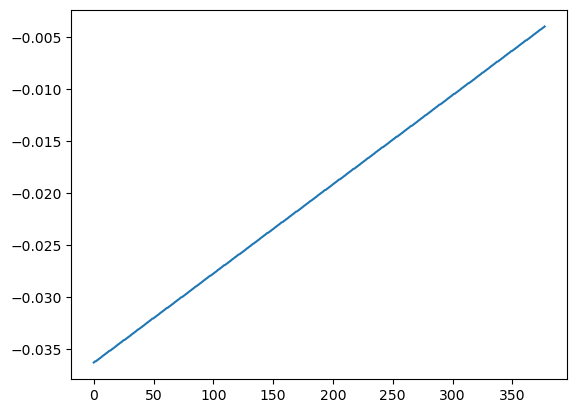

In [14]:
plt.plot(ffnew.sst_an[:,5,51,43]-fforig.sst_an[:,5,51,43])

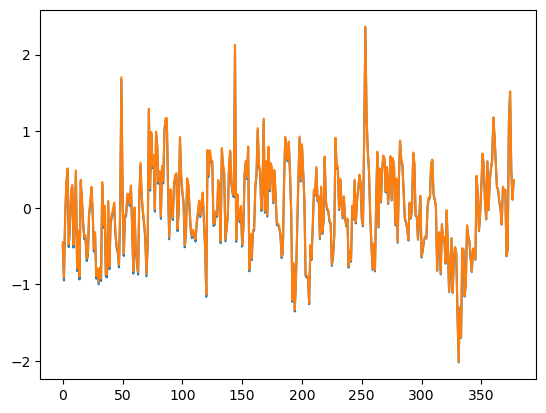

In [18]:
plt.plot(ffnew.sst_an[:,5,51,43])
plt.plot(fforig.sst_an[:,5,51,43])

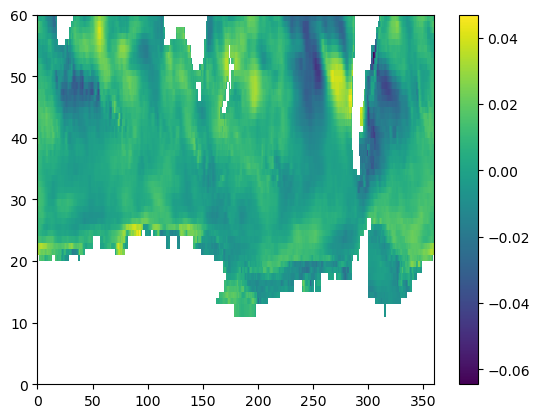

In [8]:
plt.pcolormesh(ffnewS.sst_an[25,5,:,:]-ffnew.sst_an[25,5,:,:])
plt.colorbar()

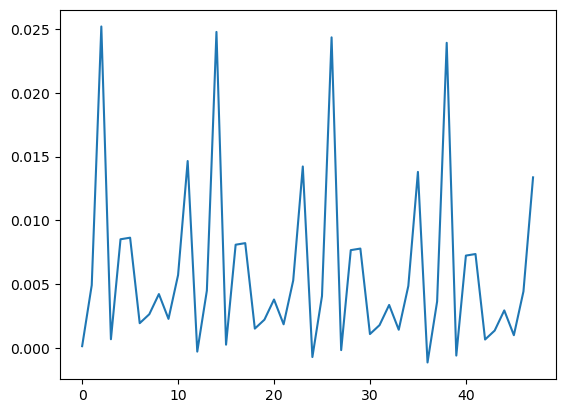

In [17]:
plt.plot(ffnewS.sst_an[:48,5,51,43]-ffnew.sst_an[:48,5,51,43])

In [35]:
ilead=5
jj=0
detr=True
smoothedClim=True
smoothedTrend=True,
delt=0

In [36]:
# version 1: 10 day windows in lead time
lmax=215
def getind(i0):
    if i0>=1 and i0<=10:
        return [i0-1,i0,i0+1]
    elif i0==0:
        return [11,0,1]
    elif i0==11:
        return [10,11,0]
def leadbounds(l0,lmax,delt):
    i0=min(max(l0-delt,0),lmax-(2*delt+1))
    return i0, i0+2*delt+1
flist=[fnameCanESMAnomDetrByLead(workdir, climyrs[0], climyrs[-1], il, jj,smoothClim=smoothedClim,smoothTrend=smoothedClim,meth=smoothmethod,win=window) \
        for il in range(*leadbounds(ilead,215,delt))]
print(flist)

['/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/anomDetrByLead_ClimStri10_TrStri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L005_j000_ocean_1d_surface_tso.nc']


In [37]:
ff=xr.open_mfdataset(flist,combine='nested',concat_dim=['leadtime'],parallel=True,decode_times=False)
ff

<xarray.Dataset> Size: 1GB
Dimensions:   (leadtime: 1, reftime: 378, r: 20, lat: 60, lon: 360)
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
  * leadtime  (leadtime) float64 8B 135.0
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * reftime   (reftime) int64 3kB 0 31 59 90 120 ... 11382 11413 11443 11474
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sst_an    (leadtime, reftime, r, lat, lon) float64 1GB dask.array<chunksize=(1, 378, 20, 60, 360), meta=np.ndarray>

In [38]:
fc=ff.sst_an.coarsen(reftime=12,boundary='pad').construct(reftime=('year','month'))
fc

<xarray.DataArray 'sst_an' (leadtime: 1, year: 32, month: 12, r: 20, lat: 60,
                            lon: 360)> Size: 1GB
dask.array<reshape, shape=(1, 32, 12, 20, 60, 360), dtype=float64, chunksize=(1, 31, 12, 20, 60, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 480B -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5
  * leadtime  (leadtime) float64 8B 135.0
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    reftime   (year, month) float64 3kB 0.0 31.0 59.0 90.0 ... nan nan nan nan
  * r         (r) int64 160B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Dimensions without coordinates: year, month

In [39]:
sh=fc.shape
ql1=np.nan*np.ones((12,sh[-2],sh[-1]))
ql2=np.nan*np.ones((12,sh[-2],sh[-1]))
for ii in range(0,1):#2):
    pool1=fc.isel(month=ii).values.reshape((sh[0]*sh[1]*sh[3],sh[4],sh[5]))
    print(pool1.shape)
    ql1[ii,...]=np.nanquantile(pool1,0.9,axis=0)
    print(getind(ii))
    pool2=fc.sel(month=getind(ii)).values.reshape((sh[0]*sh[1]*3*sh[3],sh[4],sh[5]))
    print(pool2.shape)
    ql2[ii,...]=np.nanquantile(pool2,0.9,axis=0)

(640, 60, 360)
[11, 0, 1]
(1920, 60, 360)


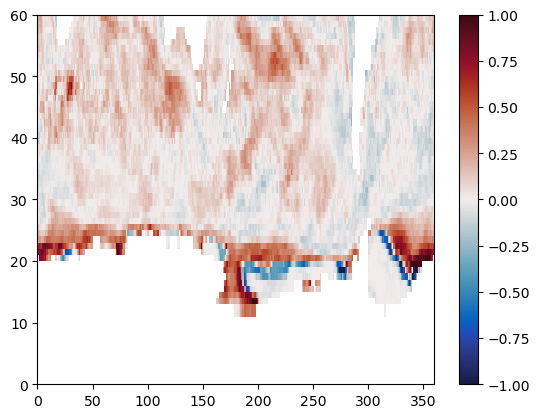

In [40]:
plt.pcolormesh(ql1[0,:,:]-ql2[0,:,:],cmap=cmocean.cm.balance,vmin=-1,vmax=1)
plt.colorbar()

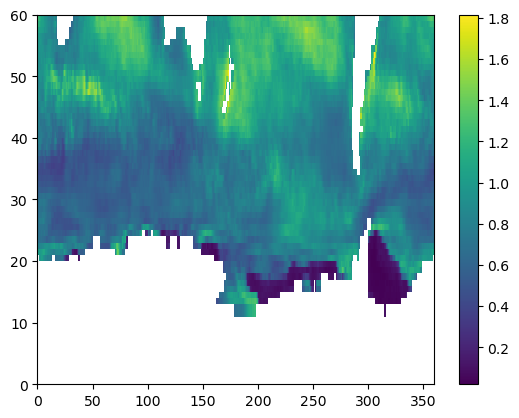

In [41]:
plt.pcolormesh(ql2[0,:,:])
plt.colorbar()

In [ ]:
fqout=fnameCanESMAnomDetrQtile(workdir, climyrs[0], climyrs[-1], ilead, jj, qtile,
                               smoothClim=smoothedClim,smoothTrend=smoothedTrend,meth=smoothmethod,win=window,delt=delt)
print(fqout)
dsqt=xr.Dataset(data_vars={'qt1':(['month','lat','lon'],ql1,{'long_name':f"{100*qtile}th percentile value"}),
                           'qt2':(['month','lat','lon'],ql2,{'long_name':f"{100*qtile}th percentile value"}),},
               coords={'month':np.arange(0,12),
                       'lat':ff.lat,
                       'lon':ff.lon})
dsqt.to_netcdf(fqout,mode='w')
del dsqt; del fc;
ff.close()